In [128]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss


import math
import time

In [129]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# 1. Load the data and get measurements

In [130]:
ROOT_PATH = "/scratch/cluster/vgorti/UTAFSDataNew/new_data"
CHIP_NUM = 2

In [131]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [132]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [133]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 581)
GT S-parameters shape:  (10, 2, 581)
Y S-parameters shape:  (10, 2, 14)


In [134]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (581,)
Y frequencies shape:  (14,)


In [135]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  1000000000.0
Mean frequency spacing:  50000000.0
STD frequency spacing:  0.0
Mode frequency spacing:  50000000.0
Number of samples with non-equal spacing:  1


In [136]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [137]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  581
N_SPARAMS:  10


In [138]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 581])


In [139]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 581])


## Plot some stuff

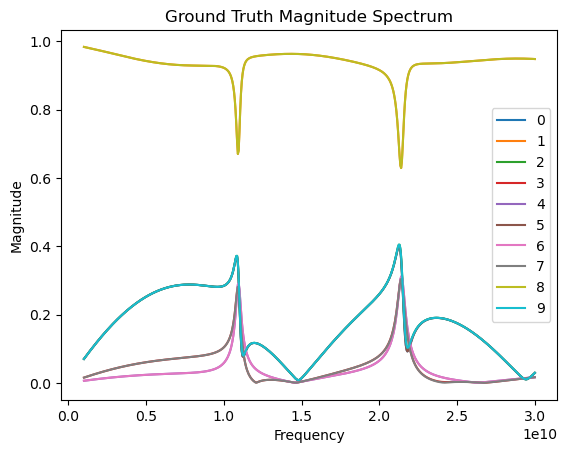

In [140]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

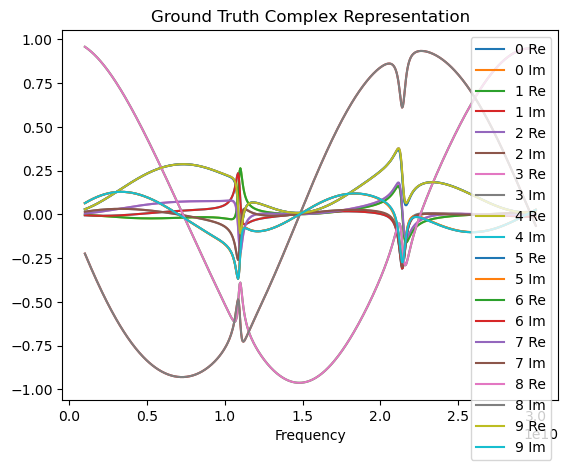

In [141]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [142]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = N_FREQS

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)

Number of Ground Truth Frequency Points:  581
Number of Measurements:  581
Undersampling Ratio:  1.0


In [143]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 581])
y_freqs shape:  (581,)


# 2. Network Setup

## Define network parameters

In [144]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ
NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = False
OPTIMIZE_Z = False
USE_SGLD = False

In [145]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  6
BASE NGF:  64
NGF:  [64, 64, 64, 64, 64, 64]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  False
OPTIMIZE_Z:  False


## Init and check dimensions

In [146]:
from models import RES_UNET, BAYESIAN_RES_UNET

const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
}



# print(net._modules['encoder']._modules['0']._modules['input_layer']._modules)
# # for layer in list(net._modules['encoder']._modules['0']._modules['input_layer']):
# #     print(layer)

import traceback
net = None
try:
    net = BAYESIAN_RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
        )
except:
    traceback.print_exc()

net = net.to(device)

In [147]:
test_out, _ = net.forward_with_z()
print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 581])


In [148]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  815616


In [149]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name + ": ", param.shape)

encoder.0.conv1.mu_kernel:  torch.Size([64, 20, 3])
encoder.0.conv1.rho_kernel:  torch.Size([64, 20, 3])
encoder.0.conv2.mu_kernel:  torch.Size([64, 64, 3])
encoder.0.conv2.rho_kernel:  torch.Size([64, 64, 3])
encoder.0.input_skip.mu_kernel:  torch.Size([64, 20, 1])
encoder.0.input_skip.rho_kernel:  torch.Size([64, 20, 1])
encoder.1.conv1.mu_kernel:  torch.Size([64, 64, 3])
encoder.1.conv1.rho_kernel:  torch.Size([64, 64, 3])
encoder.1.conv2.mu_kernel:  torch.Size([64, 64, 3])
encoder.1.conv2.rho_kernel:  torch.Size([64, 64, 3])
encoder.1.conv_skip.mu_kernel:  torch.Size([64, 64, 1])
encoder.1.conv_skip.rho_kernel:  torch.Size([64, 64, 1])
encoder.2.conv1.mu_kernel:  torch.Size([64, 64, 3])
encoder.2.conv1.rho_kernel:  torch.Size([64, 64, 3])
encoder.2.conv2.mu_kernel:  torch.Size([64, 64, 3])
encoder.2.conv2.rho_kernel:  torch.Size([64, 64, 3])
encoder.2.conv_skip.mu_kernel:  torch.Size([64, 64, 1])
encoder.2.conv_skip.rho_kernel:  torch.Size([64, 64, 1])
encoder.3.conv1.mu_kernel:  t

# 3. Run

## Define training parameters, losses, and track stats

In [177]:
LR = 1e-4 
NUM_ITER = 3000
NUM_MC_RUNS = 10

REG_HYPERPARAM = 0.01
KL_HYPERPARAM = 0

In [178]:
NOISY_INPUT = False

START_NOISE_LEVEL = CUR_NOISE_LEVEL = 10
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / NUM_ITER) 

print("Noise decay factor: ", NOISE_DECAY_FACTOR)

Noise decay factor:  0.9969345945217527


In [179]:
criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
criterion = criterion.to(device)

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

In [180]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

START_LR = LR
END_LR = LR / 10
LR_DECAY_FACTOR = (END_LR / START_LR)**(1 / NUM_ITER)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LR_DECAY_FACTOR)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [181]:
train_losses = []
train_errors = []
train_kls = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

## Train DIP

In [182]:
tic = time.time()
net.train()

for i in range(NUM_ITER):
    optim.zero_grad()

    outs_ = []
    kls_ = []
    
    for mc_run in range(NUM_MC_RUNS):
        if NOISY_INPUT:
            out_, kl_loss_ = net.forward_with_z(CUR_NOISE_LEVEL)
            # out_ = net.forward_with_z(CUR_NOISE_LEVEL)
        else:
            out_, kl_loss_ = net.forward_with_z()
            # out_ = net.forward_with_z()
        outs_.append(out_)
        kls_.append(kl_loss_)
    
    CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
    out = torch.mean(torch.stack(outs_), dim=0)
    kl_loss = torch.mean(torch.stack(kls_), dim=0)

    train_kl = KL_HYPERPARAM * kl_loss
    
    train_error = criterion(out, y) 
    if REG_HYPERPARAM > 0:
        train_reg = REG_HYPERPARAM * regularizer(out)
        train_loss = train_error + train_kl + train_reg
        # train_loss = train_error + train_reg
    else:
        train_loss = train_error + train_kl
        # train_loss = train_error
    
    train_loss.backward()
    optim.step()
    scheduler.step()

    with torch.no_grad():
        # First 20% of training will be burn-in iterations
        if USE_SGLD and i > NUM_ITER * .2:
            # Perform SGLD by adding Gaussian noise to parameters after gradient descent
            for param in net.parameters():
                # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                param.add_(torch.randn_like(param) * get_lr(optim))
        
        train_losses.append(train_loss.item())
        train_errors.append(train_error.item())
        train_kls.append(train_kl.item())
        if REG_HYPERPARAM > 0:
            train_regs.append(train_reg.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())

        if (i+1)%1000 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            if NOISY_INPUT:
                print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
            print()

ITER  0
TIME:  0.4651224613189697

ITER  999
TIME:  342.77385330200195

ITER  1999
TIME:  683.7486004829407

ITER  2999
TIME:  1025.9663813114166



In [156]:
net.eval()
NUM_FORWARD_PASSES = 1000
sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
outputs = []
for i in range(NUM_FORWARD_PASSES):
    cur_out = net.forward_with_z()[0].cpu()
    outputs.append(cur_out.data.cpu().numpy())
    sums_forward_pass_outputs += cur_out
    sums_squared_forward_pass_outputs += torch.square(cur_out)

mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

# net.eval()
# with torch.no_grad():
#     output_mc = []
#     for mc_run in range(NUM_FORWARD_PASSES):
#         logits = net.forward_with_z()
#         probs = torch.nn.functional.softmax(logits, dim=-1)
#         output_mc.append(probs)
#     output = torch.stack(output_mc)  
#     pred_mean = output.mean(dim=0)
#     y_pred = torch.argmax(pred_mean, axis=-1)


In [157]:
# from bayesian_torch.utils.util import predictive_entropy, mutual_information

# predictive_uncertainty = predictive_entropy(outputs)
# model_uncertainty = mutual_information(outputs)
# print(predictive_uncertainty, model_uncertainty)

## Plot metrics and outputs

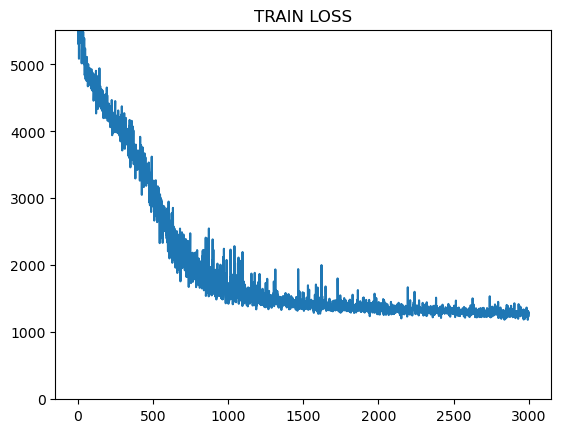

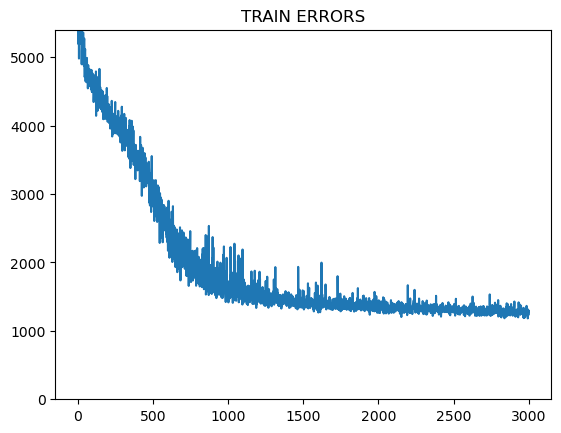

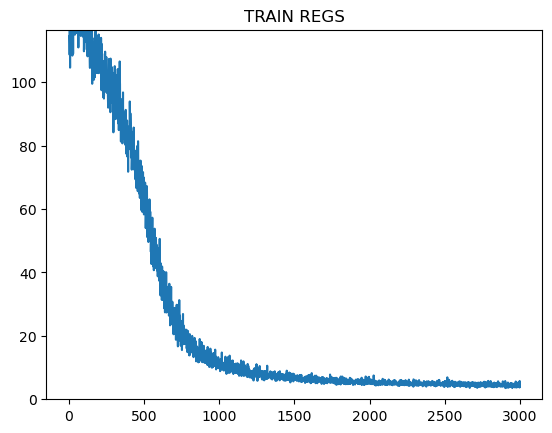

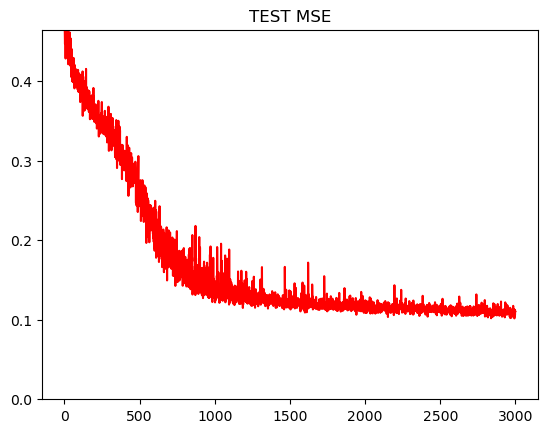

/tmp/ipykernel_68986/1565766111.py:31: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  plt.ylim(0, train_kls[0])


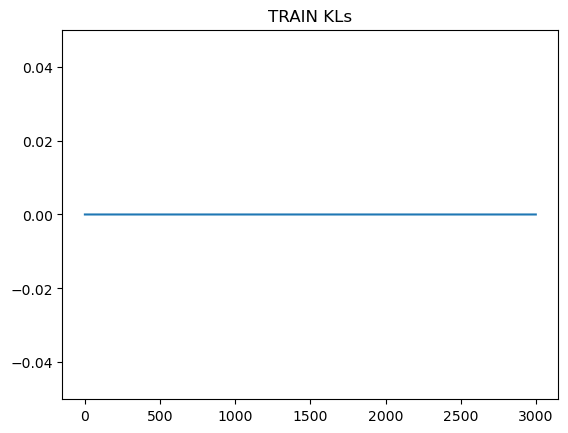

In [158]:
max_idx = NUM_ITER-1

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[0])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[0])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[0])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[0])
plt.show()

plt.figure()
plt.plot(train_kls)
plt.title("TRAIN KLs")
plt.ylim(0, train_kls[0])
plt.show()


# plt.figure()
# plt.plot(test_maes, color='g')
# plt.title("TEST MAE")
# plt.ylim(0, test_maes[0])
# plt.show()


In [159]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.11063061654567719
Best Test MSE:  0.1017211526632309
Best Test MSE Iteration:  2993


In [160]:
print(train_kls)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

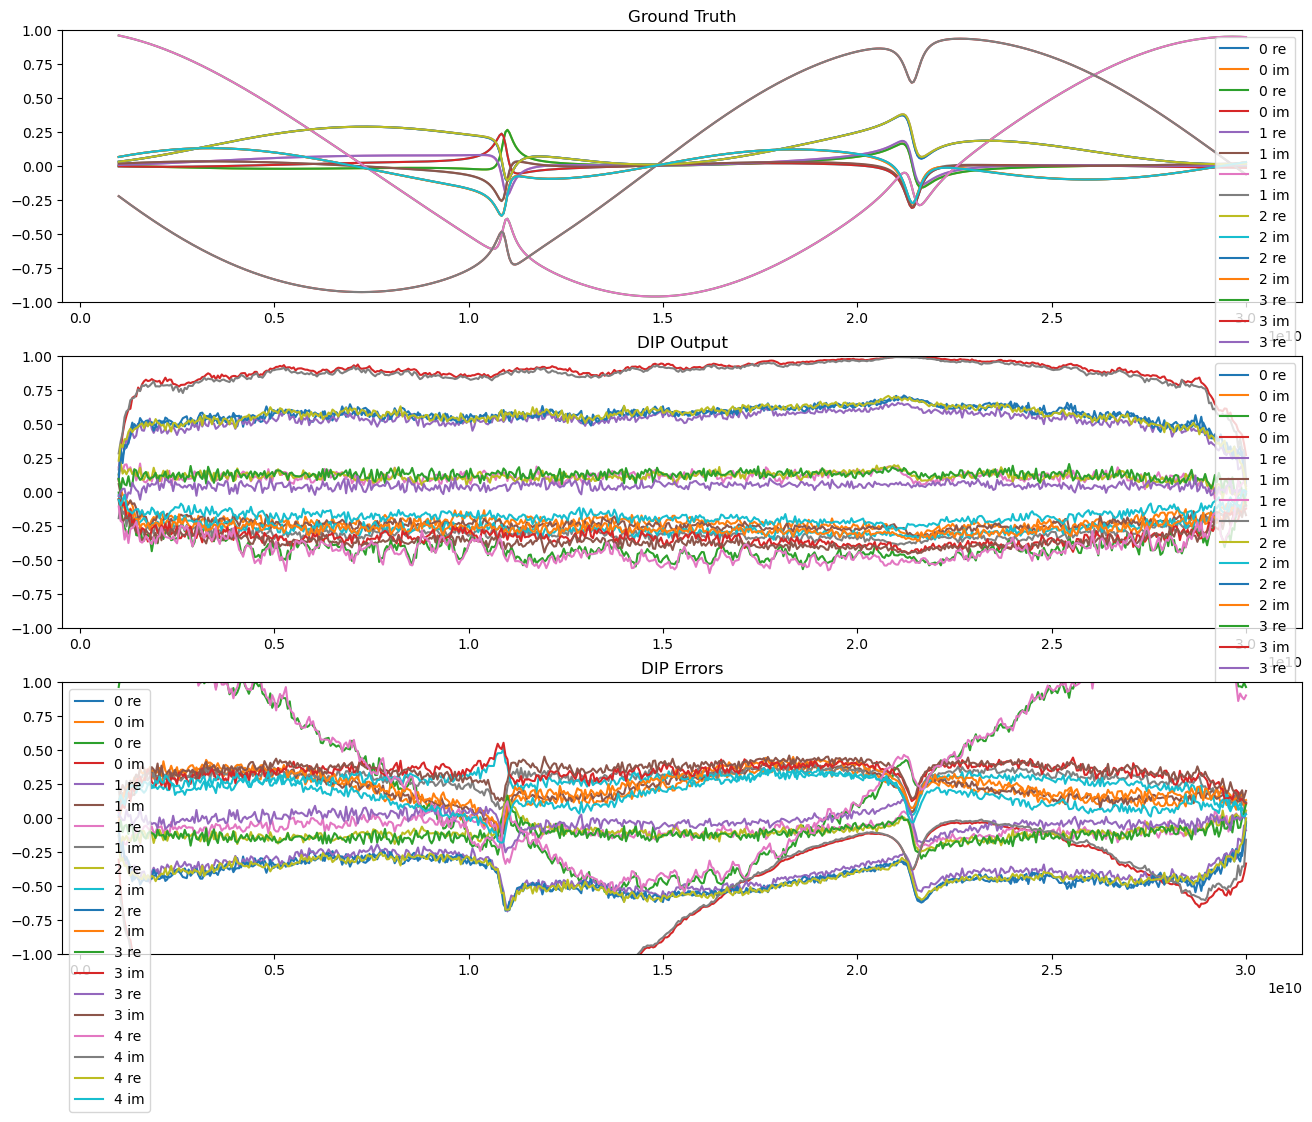

In [161]:
dip_errors = x.detach().cpu() - mean_forward_pass_outputs.detach().cpu()

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i//2)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i//2)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, mean_forward_pass_outputs[0,2*i].detach().cpu(), label=str(i//2)+" re")
    axes[1].plot(gt_freqs, mean_forward_pass_outputs[0,2*i+1].detach().cpu(), label=str(i//2)+" im")
    # axes[1].fill_between(gt_freqs, mean_forward_pass_outputs[0,2*i].detach().cpu() - std_forward_pass_outputs[0,2*i].detach().cpu(), mean_forward_pass_outputs[0,2*i].detach().cpu() + std_forward_pass_outputs[0,2*i].detach().cpu())
axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i//2)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i//2)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

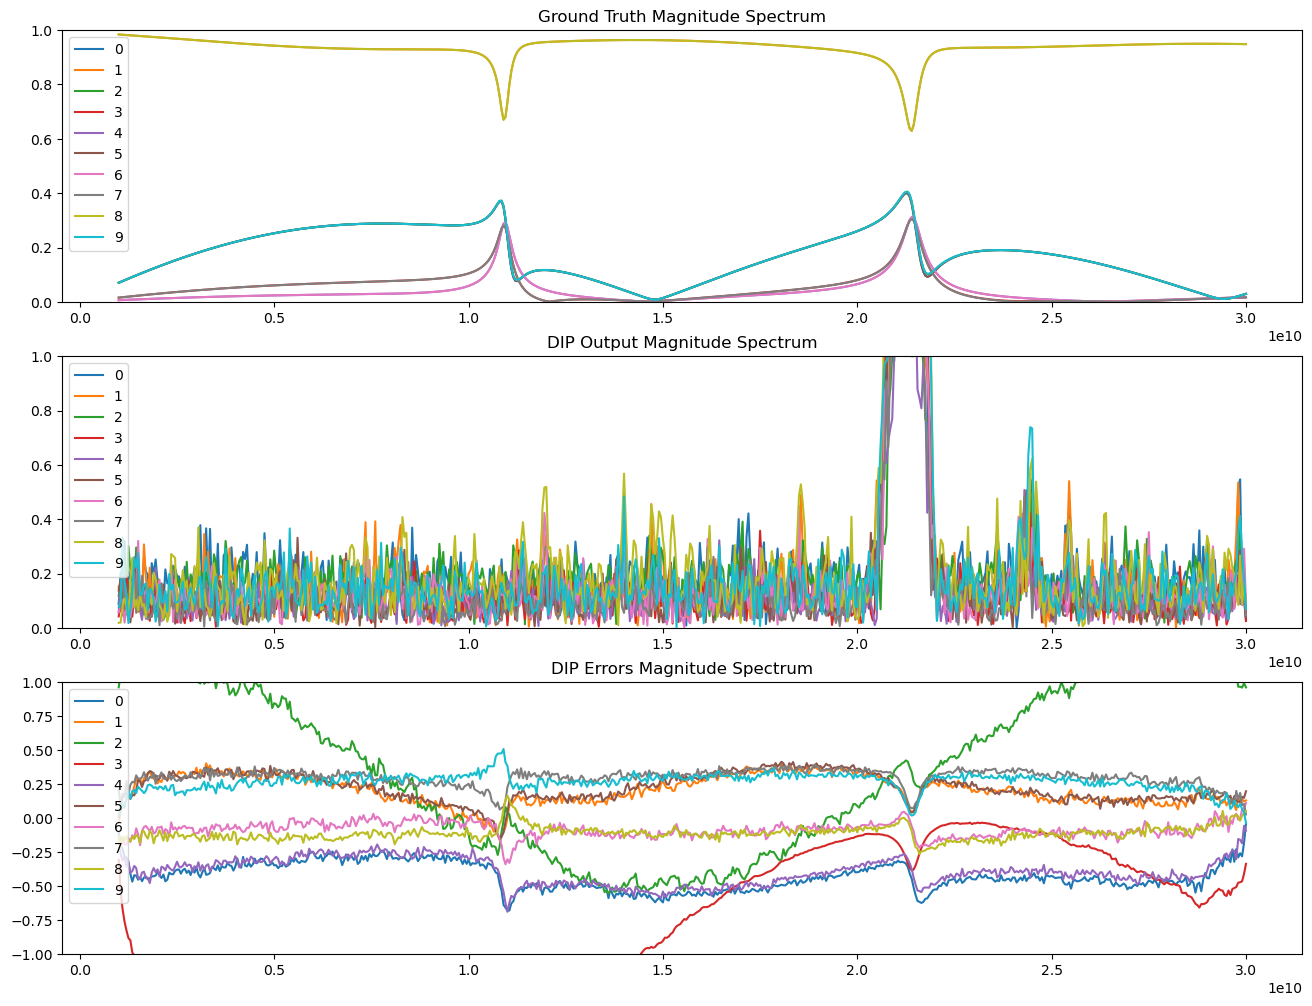

In [162]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()